In the following we will demonstrate how to coarse grain in time. For the sake of simplicity, this analysis is conducted on a smaller dataset than what is presented in the paper (this, values may different).

Running this notebook requires the following Python packages:

- NumPy
- Pandas
- Matplotlib
- SciPy

Also, it use the (homemade) `analyse` module available with companion data repository. 
This notebook analyse data from the a LAMMPS simulation by loading thermodynamic data in a `log.lammps` file. It is important that the LAMMPS simulation conducted so potential energy and virial are printed out in the log file. In practice, this is done by the following lines of the LAMMPS input script:

Here, we use the log file listed in the `log-file/T380_L35.944/`
```
...
# Compute virial
compute virial all pressure NULL virial

# Output
thermo_style custom step temp press pe ke evdwl ecoul emol vol density c_virial
...
```
 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

import analyse

# Load thermodynamic data from LAMMPS simulation
First, we will load the themodynamic data of a LAMMPS simulation of 125 ortho-terphenyl molecukes into a Pandas Dataframe using the `thermo_data_as_dataframe` from the `analyse` module.

In [3]:
time_step = 2e-15  # Time step used in simulation
steps_per_printout = 40  # Time steps per printout of thermodynamic data
spns = int(1e-9 / time_step / steps_per_printout)  # Time steps per nanosecond
print(f'Steps per nanosecond: {spns = }')
df = analyse.thermo_data_as_dataframe(
    filename='../../log-file/T380_L35.944/log.lammps', 
    time_step=time_step
)

Steps per nanosecond: spns = 12500


In [4]:
df.head()

,Time,Step,Temp,Press,PotEng,KinEng,E_vdwl,E_coul,E_mol,Volume,Density,c_virial
0,0.000000e+00,0.0,344.93695,-26171.19600,5196.6258,4111.7379,-647.60531,2486.3671,6072.3676,46438.611,1.02942,-30218.6240
1,8.000000e-14,40.0,384.74831,-1813.19590,5029.1247,4586.2996,-393.51470,2504.6959,5631.3149,46438.611,1.02942,-6327.7625
2,1.600000e-13,80.0,386.35782,2081.59420,4969.0675,4605.4855,-359.18030,2485.0399,5558.2705,46438.611,1.02942,-2451.8581
3,2.400000e-13,120.0,386.06626,-548.78717,4866.6535,4602.0099,-478.21544,2501.6095,5557.8171,46438.611,1.02942,-5078.8183
4,3.200000e-13,160.0,376.68499,2197.93110,5051.6645,4490.1828,-390.06892,2511.7764,5645.6552,46438.611,1.02942,-2222.0219


In [5]:
print(f'Trajectory of {df.Time.max()/1e-9} ns')

Trajectory of 200.0 ns


# Potential energy and virial fluctuations

First, let us investigate the instantanious fluctuations of potential energy ($U$) and virial ($W$). To show both quantaties on the same plot we will show $(y(t)-\langle y\rangle)/\sigma_y$ where $y$ is either $U$ or $W$, and 
$$\sigma_y=\sqrt{\langle (\Delta y)^2\rangle}$$
 with $\Delta y = y-\langle y\rangle$ is the standard deviation.

In [6]:
U = df.PotEng    # Potential energy
W = df.c_virial  # Viral

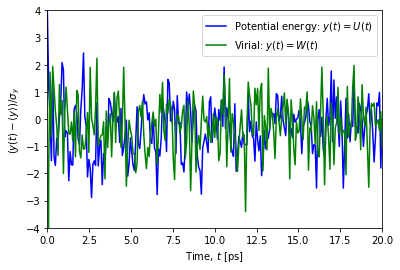

In [7]:
# Plot normalized U and W fluctuations 
plt.figure()
plt.plot(df.Time*1e12, (U-U.mean())/U.std(),
         'b-', label='Potential energy: $y(t)=U(t)$')
plt.plot(df.Time*1e12, (W-W.mean())/W.std(), 
         'g-', label='Virial: $y(t)=W(t)$')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.xlabel(r'Time, $t$ [ps]')
plt.ylabel(r'$(y(t)-\langle y\rangle)/\sigma_y$')
plt.legend()
plt.show()

The fluctuations apear nearly uncorrelated, this can be quantified by the Pearson correlation coefficient
$$
  R_{UW} = \frac{\langle\Delta U\Delta W\rangle}{\sigma_U\sigma_W}
$$
being close to zero.

In [8]:
print(f'Pearson Correlation coefficient: R_UW={np.corrcoef(W, U)[0, 1]:0.2}')

Pearson Correlation coefficient: R_UW=0.012


# Boxcar averages

Next, we wish to investigate slow fluctuations by conducting a boxcar average with window width of $\tau=1$ ns. An boxcar average is defined as taking the average if $y(t)$ from $t$ to $t+\tau$ with equal weights. 

For this, we use the `uniform_filter1d` from the SciPy library. We will refered to the temporally averaged quantaties as $\bar U$ and $\bar W$ for the potential energy and virial, respectively.

In [9]:
U_bar = uniform_filter1d(U, int(spns))  # boxcar average over 1 ns
U_bar = U_bar[spns:-spns]  # Remove edge (not computed correctly)
W_bar = uniform_filter1d(W, int(spns))
W_bar = W_bar[spns:-spns]
time = df.Time[spns:-spns]

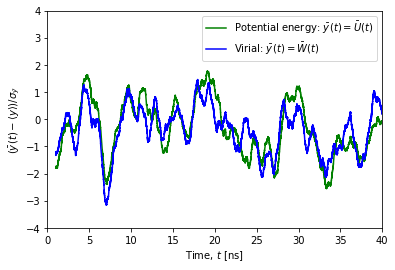

In [10]:
# Plot normalized boxcar fluctuations

plt.figure()
plt.plot(time*1e9, (U_bar-U_bar.mean())/U_bar.std(),
         'g-', label=r'Potential energy: $\bar y(t)=\bar U(t)$')
plt.plot(time*1e9, (W_bar-W_bar.mean())/W_bar.std(),
            'b-', label=r'Virial: $\bar y(t)=\bar W(t)$')
plt.xlim(0, 40)
plt.ylim(-4, 4)
plt.xlabel(r'Time, $t$ [ns]')
plt.ylabel(r'$(\bar y(t)-\langle y\rangle)/\sigma_{\bar y}$')
plt.legend()
plt.show()

Clearly, the slow fluctuations are correlated, as seen by the Pearson correlation coefficient being close to unity (indicating a hidden-scaleinvariance of slow fluctuations of the energy landscape).

In [11]:
print(f'Pearson Correlation coefficient: {np.corrcoef(W_bar, U_bar)[0, 1]:0.2}')

Pearson Correlation coefficient: 0.84


The estimate for the density scaling exponent $\gamma$ can be estimated as
$$
  \gamma_{\bar U\bar W} = \frac{\langle(\Delta \bar U\Delta \bar W)\rangle}{\langle(\Delta \bar U)^2\rangle}
$$

In [12]:
gamma = np.cov(U_bar, W_bar)[0, 1]/np.var(U_bar)
print(f'Density scaling exponent: {gamma:0.2}')

Density scaling exponent: 6.7


Note that the density scaling exponent is the identical the slope of the best linear fit with $\bar U$ on the x-axis and $\bar W$ on the y-axis.

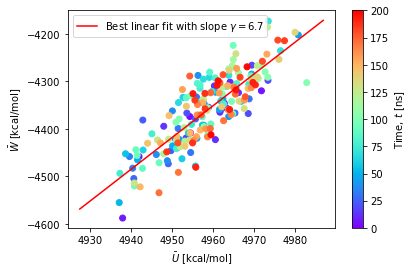

In [13]:
plt.figure()
plt.scatter(U_bar[::spns], W_bar[::spns], c=time[::spns]*1e9, 
            vmin=0, vmax=200, cmap='rainbow')
intercept = W_bar.mean() - gamma*U_bar.mean()
x_fit = np.linspace(U_bar.min(), U_bar.max(), 10)
plt.plot(x_fit, gamma*x_fit + intercept, 
         'r-', label=r'Best linear fit with slope $\gamma=$' f'{gamma:0.2}')
plt.xlabel(r'$\bar U$ [kcal/mol]')
plt.ylabel(r'$\bar W$ [kcal/mol]')
plt.legend()
cbar = plt.colorbar()
cbar.set_label(r'Time, $t$ [ns]')
plt.show()

# Time-correlation functions

The time-correlation function of the potential energy and virial is defined as
$$
  C_{yy}(t) = \lim_{{T_0}\to\infty}\frac{1}{T_0}\int_0^{T_0} y(t')y(t'+t)dt'
$$
where $y$ is either $U$ or $W$.
In practice is computed using the Wiener-Khinchin theorem. Here we use the implementation in the `analyse` module. The time-correlation function area averaged over logarithmic time intervals.

Below we compute and plot the time-correlation functions for the potential energy, virial, and their cross-correlation.

In [14]:
# Compute time-correlation functions
C_UU_all = analyse.time_correlation(U)
C_WW_all = analyse.time_correlation(W)
C_WU_all = analyse.time_correlation(W, U)

In [15]:
# Average on logarithmic scale
t = analyse.run_avg_log(df.Time)
C_UU = analyse.run_avg_log(C_UU_all)
C_WW = analyse.run_avg_log(C_WW_all)
C_WU = analyse.run_avg_log(C_WU_all)

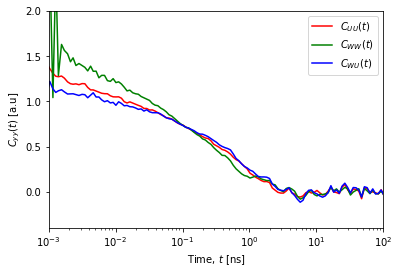

In [16]:
# Plot time-correlation functions (shifted on y-axis for clarity)
plt.figure()
plt.plot(t*1e9, C_UU/150, 'r-', label=r'$C_{UU}(t)$')
plt.plot(t*1e9, C_WW/10000, 'g-', label=r'$C_{WW}(t)$')
plt.plot(t*1e9, C_WU/1000, 'b-', label=r'$C_{WU}(t)$')
plt.xlim(0.0001, None)
plt.ylim(-0.4, 2)
plt.xscale('log')
plt.xlim(1e-3, 100)
plt.xlabel(r'Time, $t$ [ns]')
plt.ylabel(r'$C_{yy}(t)$ [a.u]')
plt.legend()
plt.show()

The scaling exponent is estimated from
$$
  \gamma_{C}(t) = \frac{C_{UW}(t)}{C_{UU}(t)}
$$


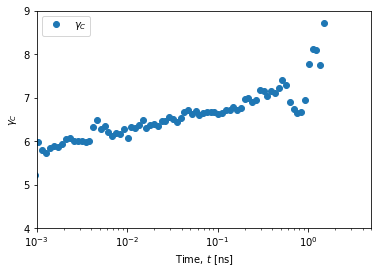

In [17]:
plt.figure()
plt.plot(t[0:90]*1e9, C_WU[0:90]/C_UU[0:90], 'o', label=r'$\gamma_{C}$')
plt.xlim(1e-3, 5)
plt.ylim(4, 9)
plt.xscale('log')
plt.xlabel(r'Time, $t$ [ns]')
plt.ylabel(r'$\gamma_{C}$')
plt.legend()
plt.show()

# Frequency-dependent Response approach
The generalized frequency-dependent response function is defined as
$$
\mu_{fg}(\omega) = \int_0^\infty \dot C_{fg}(t)\exp(-i \omega t)dt
$$
where $f$ and $g$ are either $U$ or $W$, and $\dot C_{fg}(t)=\frac{d}{dt}C_{fg}(t)$.

Below we use the `analyse` module to compute the frequency-dependent response functions. 

In [18]:
dt = float(df.Time[1] - df.Time[0])*1e9  # Time step in ns
omega_full, mu_UU_full = analyse.frequency_dependent_response(U, U, dt=dt)
_, mu_WW_full = analyse.frequency_dependent_response(W, W, dt=dt)
_, mu_UW_full = analyse.frequency_dependent_response(U, W, dt=dt)

In [19]:
# Average on logarithmic scale
omega = analyse.run_avg_log(omega_full)
mu_UU = analyse.run_avg_log(mu_UU_full)
mu_WW = analyse.run_avg_log(mu_WW_full)
mu_UW = analyse.run_avg_log(mu_UW_full)

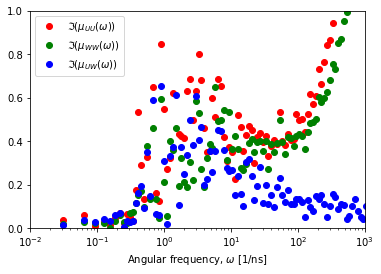

In [20]:
plt.figure()
plt.plot(omega, np.imag(mu_UU)/100, 'ro', label=r'$\Im(\mu_{UU}(\omega))$')
plt.plot(omega, np.imag(mu_WW)/10000, 'go', label=r'$\Im(\mu_{WW}(\omega))$')
plt.plot(omega, np.imag(mu_UW)/1000, 'bo', label=r'$\Im(\mu_{UW}(\omega))$')
plt.xscale('log')
plt.xlim(1e-2,1e3)
plt.ylim(0, 1)
plt.legend()
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]')
plt.show()

The scaling exponent is estimated from
$$
  \gamma_{\mu}(\omega) = \frac{\Im(\mu_{UW}(\omega))}{\Im(\mu_{UU}(\omega))}
$$


/var/folders/60/sh47svf90t56m85qnl3kd58m0000gn/T/ipykernel_68532/90500286.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(omega, np.imag(mu_UW)/np.imag(mu_UU), 'o', label=r'$\gamma_{\mu}$')


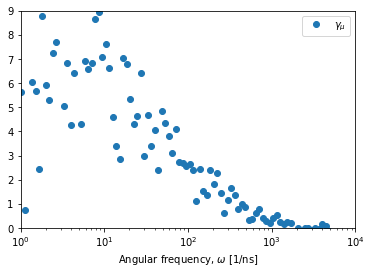

In [21]:
plt.figure()
plt.plot(omega, np.imag(mu_UW)/np.imag(mu_UU), 'o', label=r'$\gamma_{\mu}$')
plt.xscale('log')
plt.xlim(1,1e4)
plt.ylim(0, 9)
plt.legend()
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]')
plt.show()